In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

## More data cleaning and experimentation

In [3]:
file_name = "/Users/dafirebanks/Downloads/SongCSV.csv"
df = pd.read_csv(file_name)

In [4]:
df = df.fillna(0)

In [5]:
df.columns

Index(['SongNumber', 'SongID', 'AlbumID', 'AlbumName', 'ArtistFamiliarity',
       'ArtistHotttnesss', 'ArtistID', 'ArtistLatitude', 'ArtistLocation',
       'ArtistLongitude', 'ArtistName', 'BarsConfidence', 'BarsStart',
       'BeatsConfidence', 'BeatsStart', 'Danceability', 'Duration',
       'EndOfFadeIn', 'Energy', 'KeySignature', 'KeySignatureConfidence',
       'Loudness', 'Mode', 'ModeConfidence', 'SectionsConfidence',
       'SectionsStart', 'SegmentsConfidence', 'SegmentsLoudnessMax',
       'SegmentsLoudnessMaxTime', 'SegmentsLoudnessMaxStart',
       'SegmentsPitches', 'SegmentsStart', 'SegmentsTimbre', 'SongHotttnesss',
       'TatumsConfidence', 'TatumsStart', 'Tempo', 'TimeSignature',
       'TimeSignatureConfidence', 'Title', 'Year'],
      dtype='object')

In [7]:
# Columns that have lists as values
list_columns = ["BarsConfidence", "BarsStart", "BeatsConfidence", "BeatsStart", "SectionsConfidence", "SectionsStart", 
                "SegmentsConfidence", "SegmentsLoudnessMax", "SegmentsLoudnessMaxTime", "SegmentsLoudnessMaxStart", 
                "SegmentsStart", "TatumsConfidence", "TatumsStart"]

In [8]:
def transform_str_to_list(df, columns):
    for col in columns:
        all_cells = []
        
        # Modify each cell 
        for i in range(0, len(df[col])):
            
            # Get list
            horrid_string = df[col][i]
            
            # Remove non-float values
            pretty_string = horrid_string.replace("[", "").replace("]", "").replace("...", "")
            
            # Convert to a list of floats
            pretty_list = pretty_string.split()
            try:
                beautiful_list = np.array([float(el) for el in pretty_list])
            except:
                print(col, i)
                print(pretty_list)
            
            # Add to list of cells
            all_cells.append(beautiful_list)
        
        # Make it a new column
        df[col] = pd.Series(all_cells)

In [9]:
transform_str_to_list(df, list_columns)

In [11]:
# Transform all arrays to the minimum
def reduce_arrays(col_name):
    col = df[col_name]
    
    min_len = len(col[0])
    
    # Get minimum length 
    for i in range(len(col)):
        cell = col[i]
        
        # Check that the list is not empty and that all the elements are not 0
        if len(cell) < min_len and len(cell) != 0 and not all(v == 0.0 for v in cell):    
            min_len = len(cell)
#             print(i, len(cell), cell)

#     print("Minimum length is", min_len)
        
    # Transform all arrays in the column to the minimum length
    for i in tqdm(range(len(col))):
        cell = col[i]
        
        # If we stumble upon a zero array or an empty array...
        if len(cell) == 0 or len(cell) < min_len:
            col[i] = np.zeros(min_len)
        else: # We get the first min_len elements
            col[i] = col[i][:min_len]
    
    return col

In [12]:
# Make all the lists in the columns to be the same length (the length of the smallest list)
for name in list_columns:
    df[name] = reduce_arrays(name)

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 32/10000 [00:00<05:39, 29.36it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 10000/10000 [04:15<00:00, 39.08it/s]


In [13]:
df.to_csv("Clean_Songs.csv") 

## Building models!
### Data prep

In [95]:
# 2 dataframes: 1 with list averages, and the other one with uniform length lists
list_df = pd.read_csv("Clean_Songs.csv")
average_df = pd.read_csv("average_df.csv")

In [96]:
# Drop unnecessary columns
list_df = list_df.drop(columns=["Unnamed: 0"])
average_df = average_df.drop(columns=["Unnamed: 0", "Energy", "SegmentsPitches", "SegmentsTimbre", 'SongID', 'SongNumber', 'AlbumName', 'AlbumID', 'ArtistID', 
                              'ArtistLocation', 'ArtistName', 'Title'])

In [97]:
# Choose one of the dfs to work with, choose is_listdf to be True or False accordingly
df = list_df
is_listdf = True 

In [102]:
# If we want to use list data, make the list part of the observation rather than having a list of lists
def flatten_lists(data):
    new_data = []
    
    for obs in data:
        new_el = []
        for el in obs:
            if isinstance(el, str):
                corrected_els = [float(e) for e in el.replace("]", "").replace("[", "").split()]
                new_el.extend(corrected_els)
            else:
                new_el.append(el)
        
        new_data.append(new_el)
    
    return np.array(new_data)

In [103]:
# PREPROCESSING!!!!!

# Make the target variable binary 
# TODO What if we make this above average rather than 0.5
df["SongHotttnesss"] = pd.Series([1 if i > 0.5 else 0 for i in df["SongHotttnesss"]])

# Target variable index
tg_idx = df.columns.get_loc("SongHotttnesss")

# Get your X and y
numeric_data = df.values
y = numeric_data[:, tg_idx].astype(float)
X = np.delete(numeric_data, tg_idx, 1)

# Flatten lists IF USING DF 
if is_listdf:
    X = flatten_lists(X)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(10000, 64) (10000,)


In [187]:
# Method to test any classifier and print metrics
def test_classifier(clf, X_test, y_test, grid_search=False):
    preds = clf.predict(X_test)
    
    # Normal metrics
    print("GENERAL METRICS:")
    print("Accuracy: ", metrics.accuracy_score(y_test, preds))
    print("Precision: ", metrics.precision_score(y_test, preds))
    print("Recall: ", metrics.recall_score(y_test, preds))
    print("F1 score: ", metrics.f1_score(y_test, preds))
    print()
    print(classification_report(y_test, preds))
    print()
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print("Original Confusion Matrix")
    print(cm)
    print()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=['Not Hot','Hot'], normalize=True,
                          title='Confusion matrix')
    
    print()
    print("ROC curve + Confusion matrix")
    
    # ROC curve (from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
    pred_probs = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  pred_probs)
    auc = roc_auc_score(y_test, pred_probs)
    plt.subplot(1, 2, 2)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    
    plt.show()
    
    # Best parameters
    if grid_search:
        print("Best parameters for classifier are:")
        print(clf.best_params_)
    
    return preds

# CODE TAKEN FROM SKLEARN CONFUSION MATRIX PAGE! -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Random Forest

In [106]:
# Model
rf = RandomForestClassifier(random_state=42)

In [107]:
rf_params = {'max_depth':[3, 8, 15, 20], 'class_weight':["balanced", "balanced_subsample"], "min_samples_split":[2, 5, 7], "criterion":["gini", "entropy"]}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=10, scoring="f1")

In [108]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 8, 15, 20], 'class_weight': ['balanced', 'balanced_subsample'], 'min_samples_split': [2, 5, 7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

GENERAL METRICS:
Accuracy:  0.774
Precision:  0.4104979811574697
Recall:  0.7060185185185185
F1 score:  0.5191489361702127

             precision    recall  f1-score   support

        0.0       0.93      0.79      0.85      2068
        1.0       0.41      0.71      0.52       432

avg / total       0.84      0.77      0.79      2500


Original Confusion Matrix
[[1630  438]
 [ 127  305]]

Normalized confusion matrix
[[0.78820116 0.21179884]
 [0.29398148 0.70601852]]

ROC curve + Confusion matrix


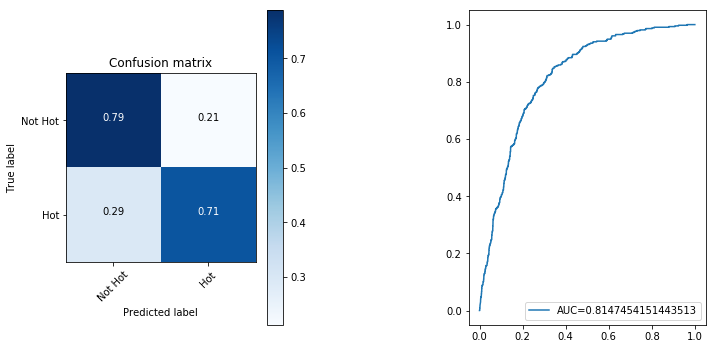

Best parameters for classifier are:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5}


In [188]:
gsrf_preds = test_classifier(gs_rf, X_test, y_test, grid_search=True)

In [256]:
best_rf = RandomForestClassifier(class_weight="balanced", criterion="entropy", max_depth=8, min_samples_split=5, random_state=42)

In [257]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### Gradient Boosting

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

In [166]:
gb = GradientBoostingClassifier(random_state=42)

In [178]:
# Experimenting with params
gb_params = {"max_depth":[3, 5, 8, 11], 
             "min_samples_split":[2, 4, 6, 8], 
             "n_estimators":[100, 500, 1000]}

gs_gb = GridSearchCV(gb, param_grid=gb_params, cv=10, scoring="f1", verbose=5)

In [ ]:
gs_gb.fit(X_train, y_train)

GENERAL METRICS:
Accuracy:  0.8316
Precision:  0.5212355212355212
Recall:  0.3125
F1 score:  0.3907380607814761

             precision    recall  f1-score   support

        0.0       0.87      0.94      0.90      2068
        1.0       0.52      0.31      0.39       432

avg / total       0.81      0.83      0.81      2500


Original Confusion Matrix
[[1944  124]
 [ 297  135]]

Normalized confusion matrix
[[0.94003868 0.05996132]
 [0.6875     0.3125    ]]

ROC curve + Confusion matrix


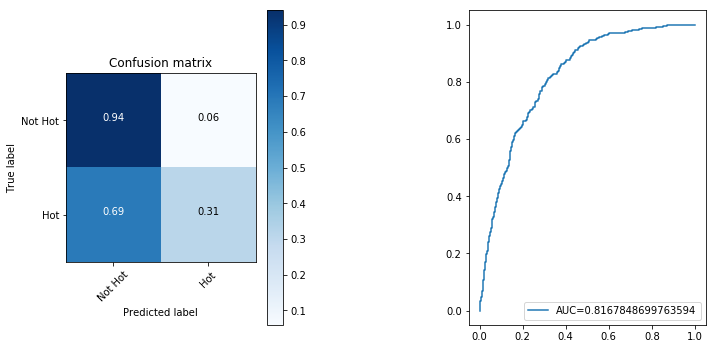

Best parameters for classifier are:
{'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 1000}


In [189]:
gsgb_preds = test_classifier(gs_gb, X_test, y_test, grid_search=True)

In [265]:
best_gb = GradientBoostingClassifier(n_estimators=1000, max_depth=3, min_samples_split=6, random_state=42)

In [ ]:
best_gb.fit(X_train, y_train)

### AdaBoost

In [155]:
from sklearn.ensemble import AdaBoostClassifier

In [156]:
ab = AdaBoostClassifier(n_estimators=500, random_state=0)
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=0)

GENERAL METRICS:
Accuracy:  0.8236
Precision:  0.48464163822525597
Recall:  0.3287037037037037
F1 score:  0.3917241379310345

             precision    recall  f1-score   support

        0.0       0.87      0.93      0.90      2068
        1.0       0.48      0.33      0.39       432

avg / total       0.80      0.82      0.81      2500


Original Confusion Matrix
[[1917  151]
 [ 290  142]]

Normalized confusion matrix
[[0.92698259 0.07301741]
 [0.6712963  0.3287037 ]]

ROC curve + Confusion matrix


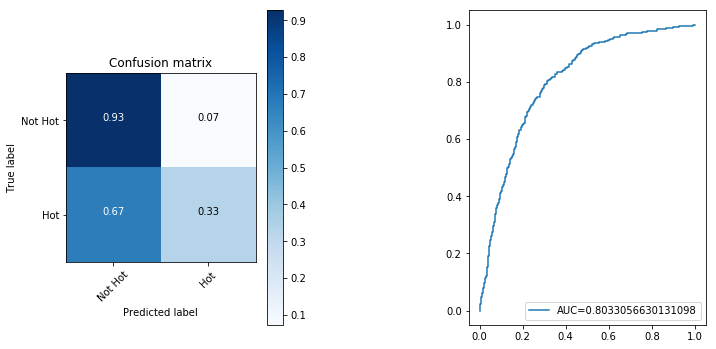

In [157]:
ab_preds = test_classifier(ab, X_test, y_test, grid_search=False)

### Testing threshold values

In [263]:
# Code from homework 5
def modified_f1(threshold):
    def f1_threshold(clf, X, y):
        y_pred = predict_with_threshold(clf, X, threshold)
        return metrics.f1_score(y, y_pred)
        
    return f1_threshold

def predict_with_threshold(clf, X, threshold):    
    pred_probs = clf.predict_proba(X)
    decision = [1 if p > threshold else 0 for p in pred_probs[:,1]]
    
    return decision

# Method to test multiple threshold values for prediction
def test_threshold_values(t_values, clf, X, y):
    results = []
    
    for t in tqdm(t_values):
        result = cross_val_score(clf, X, y, scoring=modified_f1(t), cv=10)
        results.append(result)
    
    # PLOT THRESHOLD VALUES FOR PREDICTION AGAINST F1 SCORE! (Code from homework 5)
    sns.boxplot(x=t_values, y=results)
    plt.xlabel("Threshold Values")
    plt.ylabel("Scores")
    plt.title("Cross validation scores per threshold values")
    plt.show()
    
    return results

# FEATURE IMPORTANCE PER CLASSIFIER (Code from homework 5)
def show_feature_importance(clf, feature_list):
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = feature_list,
                                    columns=['importance']).sort_values('importance', ascending=False)
    feature_importances.plot.bar(figsize=(15, 5))

###### CODE TO GET CUMMULATIVE IMPORTANCE OF FEATURES
## TAKEN FROM https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

def show_cumulative_importance(clf, feature_list):
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    x_values = list(range(len(importances)))

    # for pair in feature_importances:
    #     print('Variable: {:20} Importance: {}'.format(*pair))

    # List of features sorted from most to least important
    sorted_importances = [importance[1] for importance in feature_importances]
    sorted_features = [importance[0] for importance in feature_importances]
    # Cumulative importances
    cumulative_importances = np.cumsum(sorted_importances)
    # Make a line graph
    plt.figure(figsize=(15, 5))
    plt.plot(x_values, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_values, sorted_features, rotation = 'vertical')
    # Axis labels and title
    plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
t_values = [0.2, 0.5]#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scores = test_threshold_values(t_values, gs_rf, X_test, y_test)

In [232]:
features = list(df.columns)

# LENGTH OF LISTS OF LIST FEATURES!
# ["BarsConfidence" (2), "BarsStart" (2), "BeatsConfidence", (6) "BeatsStart (6)", "SectionsConfidence (2)", "SectionsStart" (4), 
#                 "SegmentsConfidence" (3), "SegmentsLoudnessMax"(4), "SegmentsLoudnessMaxTime" (4), "SegmentsLoudnessMaxStart" (4), 
#                 "SegmentsStart (4)", "TatumsConfidence (3)", "TatumsStart"(3)]

extended_features = []
for f in features:
    if f == "BarsConfidence":
        extended_features.extend(["BarsConfidence 1", "BarsConfidence 2"])
    elif f == "BarsStart":
        extended_features.extend(["BarsStart 1", "BarsStart 2"])
    elif f == "BeatsConfidence":
        extended_features.extend(["BeatsConfidence 1", "BeatsConfidence 2", "BeatsConfidence 3", 
                                  "BeatsConfidence 4", "BeatsConfidence 5", "BeatsConfidence 6"])
    elif f == "BeatsStart":
        extended_features.extend(["BeatsStart 1", "BeatsStart 2", "BeatsStart 3", 
                                  "BeatsStart 4", "BeatsStart 5", "BeatsStart 6"])
    elif f == "SectionsConfidence":   
        extended_features.extend(["SectionsConfidence 1", "SectionsConfidence 2"])
    elif f == "SectionsStart":
        extended_features.extend(["SectionsStart 1", "SectionsStart 2", "SectionsStart 3", "SectionsStart 4"])
    elif f == "SegmentsConfidence":
        extended_features.extend(["SegmentsConfidence 1", "SegmentsConfidence 2", "SegmentsConfidence 3"])
    elif f == "SegmentsLoudnessMax":
        extended_features.extend(["SegmentsLoudnessMax 1", "SegmentsLoudnessMax 2", "SegmentsLoudnessMax 3", "SegmentsLoudnessMax 4"])
    elif f == "SegmentsLoudnessMaxTime":
        extended_features.extend(["SegmentsLoudnessMaxTime 1", "SegmentsLoudnessMaxTime 2", "SegmentsLoudnessMaxTime 3", "SegmentsLoudnessMaxTime 4"])
    elif f == "SegmentsLoudnessMaxStart":
        extended_features.extend(["SegmentsLoudnessMaxStart 1", "SegmentsLoudnessMaxStart 2", "SegmentsLoudnessMaxStart 3", "SegmentsLoudnessMaxStart 4"])
    elif f == "SegmentsStart":
        extended_features.extend(["SegmentsStart 1", "SegmentsStart 2", "SegmentsStart 3", "SegmentsStart 4"])
    elif f == "TatumsConfidence":
        extended_features.extend(["TatumsConfidence 1", "TatumsConfidence 2", "TatumsConfidence 3"])
    elif f == "TatumsStart":
        extended_features.extend(["TatumsStart 1", "TatumsStart 2", "TatumsStart 3"])
    else:
        extended_features.append(f)

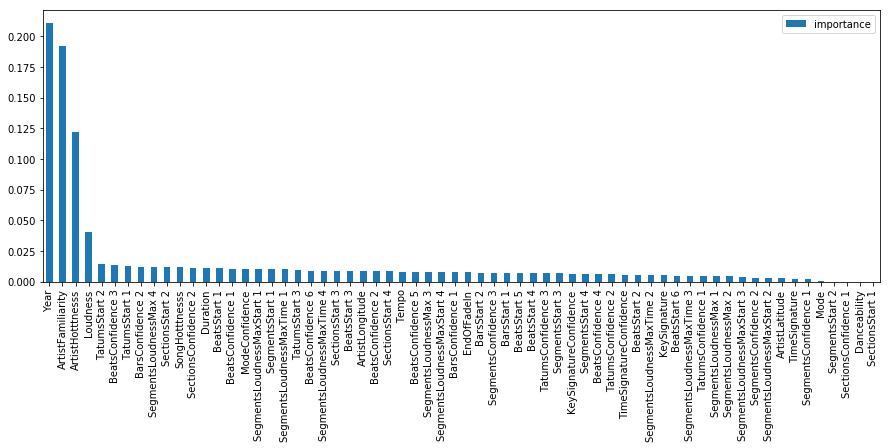

In [260]:
show_feature_importance(best_rf, extended_features)

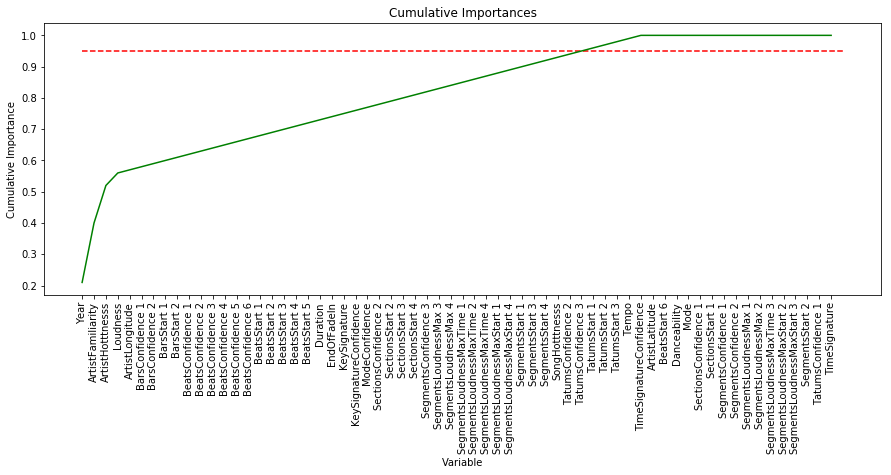

In [264]:
show_cumulative_importance(best_rf, extended_features)

In [ ]:
show_feature_importance(best_gb, extended_features)

In [ ]:
show_cumulative_importance(best_gb, extended_features)

## TODO: Testing with oversampling and undersampling

In [ ]:
from sklearn.utils import resample

In [ ]:
# Code taken from https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f

# MODIFY THIS
df_majority_downsample = resample(df_majority, 
                                 replace=True,     
                                 n_samples=105,    
                                 random_state=123) 

df_train = pd.concat([df_majority_downsample, df_minority_upsampled])